# **IP Reputation**

### We are going to look at detecting Click BOTs from a known campaign sent on Jan 17th @ 9:00AM.

#### But we want to access IP Address behavior prior to that send for likelihood the IP is a BOT

Data was gathered for all click requests for the previous 24 hours and stored in the 2020-01-17.csv file.

### All the requested in this dataset occurred before the campaign we want to study went out.

This is going to let us access the "reputation" of the IP Address.  The campaign we will be studying will have IP Address not used in these 24 hours sample, but this dataset should hold IPs with heavy use as would be expected by BOT devices.


In [71]:
import numpy as np
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

### BotDataSet Class

We will use a class to make sure the **loading**, **cleanup** and **sessionization** is done consistantly for both the IP Reputation and the Campaing dataset.  This class will also give us code reuse for the trainging and testing datasets.

In [2]:
exec(open("BotDataSet.py").read())

In [3]:
botDataSet = BotDataSet()
botDataSet.loadCSV('C:/data/2020-01-17.csv')
df = botDataSet.df

In [4]:
pd.options.display.max_columns = None
display(df.head()) 
print(df.shape)
print('RequestDate Range: {}:{}'.format(df['RequestDate'].min(), df['RequestDate'].max()))
df.nunique()

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln
0,{7C9E652E-AC29-02E0-BE9A-8C43363D665E},{0F96A485-3307-02C7-6F5F-C23BAF3CB945},{79575937-FEB1-AD59-92A5-F2BDCD8EBE25},{4ECAB404-363D-958D-4ECB-99B8D565A66E},Click,2020-01-16 11:32:00,2020-01-16 22:33:00,{CB7A65D9-3644-5395-6E60-E7A556F52E3A},{98302769-08A3-76D3-A660-FB0ED5A313CF},{1047A34C-F98E-2B84-9E69-BCBA6FEEDA97},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{C69692BD-C245-842F-7E3A-0BD44C2E52E8},{9DB20ACE-264D-4774-240E-A86A9FEBC3E6},{5236C5C5-F807-01B8-7308-6369971DE796},.au,AU,05,5000,NaN,NaN,Australia/Adelaide,39660,10.588167
1,{5C245764-B2E8-6C22-65DA-2FA633D2B83D},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{D79E0F2C-4B46-F92F-513C-D9CB4D8150C6},{8708F19F-4880-FA0F-ECCC-0656BDE3B75C},Click,2020-01-17 00:51:00,2020-01-17 04:36:00,{3536BC26-72F7-93D0-09EF-2BF0D5BF5C56},{F879CD11-C8A8-E0F2-A6CF-FFD517892C2D},{67293EF8-7DAD-4A39-0C54-A4499B81C1B0},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{D2D2EECD-86A8-F45B-58AF-ED5ECF0025B6},{7C1BFAEE-63CC-62EB-7343-BB54BBB09F34},{8BBE6FB8-C8D7-CFA8-BF17-AD7BAE195985},.com,AU,05,5000,NaN,NaN,Australia/Adelaide,13500,9.510646
2,{8AB62ABA-0FFD-E217-7EBD-8AD7ECC87559},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:49:00,2020-01-16 19:50:00,{980DC05A-AA27-25B7-7E63-71E70A813088},{7B8A27E6-F6AB-6573-BEF3-334E2E442EF5},{4B0814A1-D331-7033-76B6-F8DB28419C4E},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{07C40EB6-8768-1646-A917-110882272065},{7C1BFAEE-63CC-62EB-7343-BB54BBB09F34},{8BBE6FB8-C8D7-CFA8-BF17-AD7BAE195985},.com,AU,05,5000,NaN,NaN,Australia/Adelaide,39660,10.588167
3,{4DE4BB44-5B00-C6E0-3164-C861E43F0C62},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{ED6C0505-90EC-C31C-3A6A-70A4A193A848},Click,2020-01-16 09:03:00,2020-01-16 17:27:00,{22792626-F2A9-D1AF-AB10-413C1F949A6A},{AF6309B4-2BB3-A707-2F53-131B8DC1D6A4},{F87DC183-2EAD-5AED-B536-4545C440750D},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{59591E4C-6446-5D8C-B4BB-FE284BEC8716},{355469F6-693A-48D0-ACF7-772342C94F4E},{E1EB2A3A-3A96-7B63-669B-7BF029316F88},.com,AU,08,6000,NaN,NaN,Australia/Perth,30240,10.317011
4,{ECB3FB8D-CBA3-8EB3-B97A-88C776102D97},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:48:00,2020-01-16 21:13:00,{93D6CA84-1DFF-2FC5-A0B1-FAB6DE900639},{BB083DCF-AABB-3B20-FB03-6F9DD69BABBE},{F87DC183-2EAD-5AED-B536-4545C440750D},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{ED8E3431-6480-D006-1DFC-4F1BFE952B03},{D75C365A-E14F-D786-8B90-F5AE2456FC87},{FED8E0A7-B13C-C044-F0EB-67C14E5F143D},.com,AU,08,6000,NaN,NaN,Australia/Perth,44700,10.707790


(101061, 25)
RequestDate Range: 2020-01-16 09:00:00:2020-01-17 09:00:00


InboxID                  60675
Company                     27
List                        94
Campaign                  1033
RequestType                  1
SendDate                  5411
RequestDate               1441
Link                      5678
IPAddress                55248
UserAgent                 3917
AS Name                     24
AS Number                   25
CIDR Range                 908
UserID                   56880
DomainID                  5581
EmailDomain               5581
EmailRootLevelDomain        90
CountryCode                182
RegionCode                 202
PostalCode                7513
Lat                       4016
Long                      4195
OlsonName                  146
SendRequestSeconds        9018
SendRequestSeconds_ln     9018
dtype: int64

# Only One Metrizable Column in Raw Request Data
## But this metric is one of the major factors that we anticipate will help us identify BOTs.

Mose of the click BOTs are safty devices that examin the risk of the email before it is released to the contact's inbox. So to prevent causing a long delay, the BOTs will want to process the links as soon as they are recieved.  Through manual, most of the suspected BOTs click the message within 1 or 2 minutes after send went out.

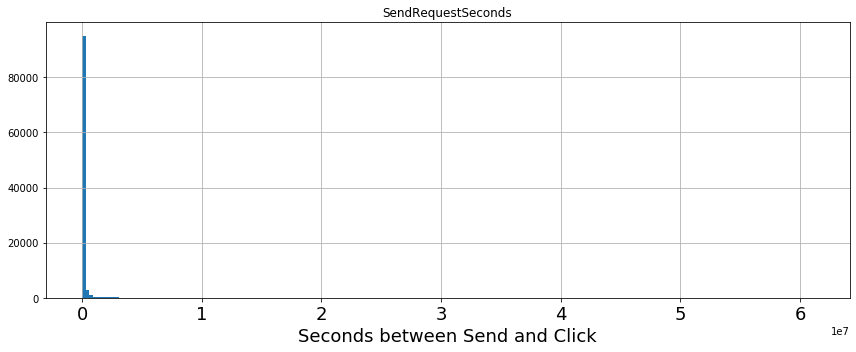

In [5]:
df.hist(column='SendRequestSeconds', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Seconds between Send and Click", fontsize=18)
plt.tight_layout()
plt.show()

## As you can see from the histogram, there is an overwelming number of clicks in the first few minusts after the send.

#### To even out this distribution, the BotDataSet class created a calculated column called **SendRequestSeconds_ln**

This was done by taking the natural log of the SendRequestSeconds.  To avoid zero and negative, the number e was added before the the log was taking.  This make the bottom of the scale = 1.  To give a feel of the upper limit of the this value, 2 days (172800 seconds) would give a value of 14.77.

## $ SendRequestSeconds\_ln = log_{e}(SendRequestSeconds + e) $

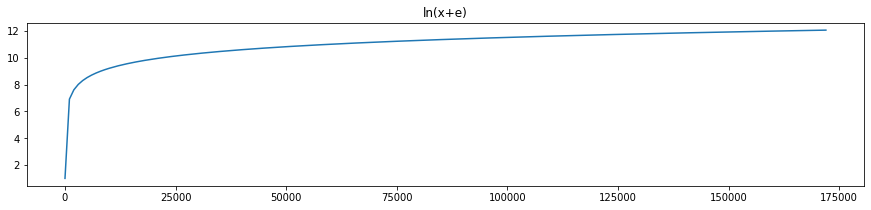

In [6]:
def ln_seconds_plus_e(t):
    return np.log(t + np.exp(1)) 
seconds = range(0, 172800, 1000)
seconds_ln =  ln_seconds_plus_e(seconds)
f = plt.figure(figsize=(15, 3))
plt.plot(seconds, seconds_ln)
plt.title('ln(x+e)')
plt.show()

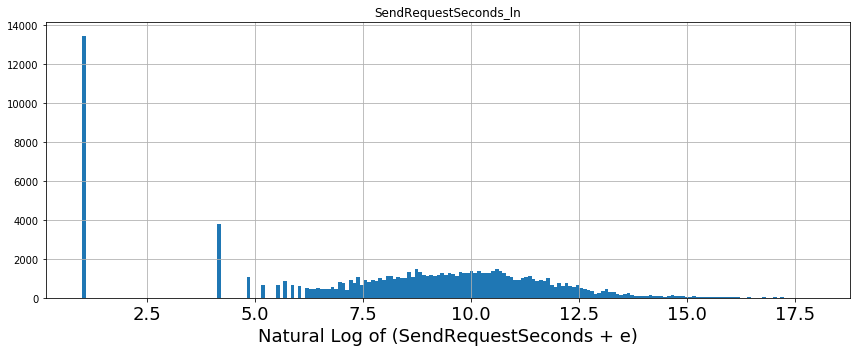

In [7]:
df.hist(column='SendRequestSeconds_ln', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Natural Log of (SendRequestSeconds + e)", fontsize=18)
plt.tight_layout()
plt.show()

## Extend Dataframe with Session Columns

The 4 "SessionIDs" built here are the same one used in the campaign analysis.

In [8]:
max_session_time_gap = timedelta(seconds=120)

session_columns = {'InboxSessionID':('InboxID', None), 
                   'IPSessionID':('IPAddress', None),
                   'IPUASessionID':('IPAddress', 'UserAgent')}

for t in session_columns.items():
    new_column_name, group_tuple = t
    group_column_1, group_column_2 = group_tuple
    botDataSet.loadSessionColumn(new_column_name, max_session_time_gap, group_column_1, group_column_2)

df = botDataSet.df

In [9]:
display_columns = ['RequestDate', 'InboxID', 'IPAddress', 'CIDR Range', 'AS Number']
display_columns.extend(list(session_columns.keys()))

sdf = df[display_columns]
display(sdf.head()) 
sdf.nunique()

,RequestDate,InboxID,IPAddress,CIDR Range,AS Number,InboxSessionID,IPSessionID,IPUASessionID
37995,2020-01-16 09:00:00,{582CF80F-649D-3184-ECE6-6EC82905B7CA},{64386B36-2523-58A3-518D-168C6A876DDA},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-6282686456393246285,-1383729496854944629,1946798281775067945
11561,2020-01-16 09:00:00,{426C37ED-B9CB-5B33-68DC-31F0051BD0EF},{A1066275-4BAE-86E3-67DA-5EC5AB520098},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,2452673572283220917,-4272135940689275703,-4227852320656417801
23119,2020-01-16 09:00:00,{515F71C9-42FF-E596-6414-684544C80531},{38803023-2C94-66E7-EBCD-338792441922},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,3059773363931904229,-5633582871466696139,7702434081616311541
92386,2020-01-16 09:00:00,{7301DAD5-438A-FDF9-1525-8AC8ACC21C9C},{488DFBAF-A009-4C64-7335-F446A28D4ECB},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-13634572772485745,4101336290164431145,-2047965215585511331
23085,2020-01-16 09:00:00,{515F71C9-42FF-E596-6414-684544C80531},{5633CFE0-E7D3-AAC1-827B-C9D090299B06},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,3059773363931904229,-5012705907559556246,-2720776536932773615


RequestDate        1441
InboxID           60675
IPAddress         55248
CIDR Range          908
AS Number            25
InboxSessionID    68089
IPSessionID       69008
IPUASessionID     70018
dtype: int64

# IP Reputation

We built sessionization 3 different ways for the IPs, **IPAddress**, **CIDR Range**, and **AS Number**.

We will start with just looking at IPAddress.  If the unsupervised clustering does not look satisfactory,  we have the option to go up the IP hierarchy.  Just using the IP Address would have very large benefits in the implementation in BOT filtering for a couple of reasons:
- No need to build an ASN Database
- No need to do ASN or CIDR lookups in real-time
- Not all IP address will find a match in the ASN DB

## IP Based Session DataFrames

### We start by grouping on the IPSessionID

This will give us two major advantages:
- We can look at the group of requests as a whole and not just request by request
- The aggregate values produced will give us metrizable data to do K-Means Clustering on

## The IPSession is all requests grouped together as long at there are not gaps grater then 2 minutes between requests.

This means that an IP that is used frequently might have large numbers of requests per IP Session, span many different emails and InboxIDs and have session durations longer than normal.

**UniqueUserAgents/UniqueEmail** - User Agents tend to be fairly unique.  Also, contact's tend to use the same browser/email client to view their emails.  So, if you hade 100 emails, you would expect to see around 50 unique User Agents.  But BOTs tend to reuse the same User Agent string so if the BOT is hitting 100 unique emails, there would tend to be only 1 or 2 unique User Agents strings.


In [10]:
generic_agg = {'IPAddress':'min',
               'IPSessionID':'count',
               'InboxID':'nunique', 
               'UserID':'nunique', 
               'EmailDomain':'nunique', 
               'EmailRootLevelDomain':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}

generic_agg_renames = { "IPSessionID": "RequestCount", 
                 "InboxID": "UniqueInboxIDs", 
                 "UserID": "UniqueEmails", 
                 "EmailDomain": "UniqueEmailDomains", 
                 "EmailRootLevelDomain": "UniqueEmailRootLevelDomain", 
                 "Link": "UniqueLinks",  
                 "SendRequestSeconds": "MeanSendRequestSeconds", 
                 "SendRequestSeconds_ln": "MeanSendRequestSeconds_ln", 
                 "RequestDate": "SessionDuration"}

generic_unsup_columns = ['RequestCount',
                   'UniqueInboxIDs',
                   'UniqueEmails',
                   'UniqueEmailDomains',
                   'MeanSendRequestSeconds_ln',
                   'SessionDuration',
                   'UniqueLinks']

Inbox_agg = generic_agg.copy() 
Inbox_agg_renames = generic_agg_renames.copy()
Inbox_unsup_columns = generic_unsup_columns.copy()
Inbox_agg.update([('UserAgent','nunique')]) # Since UA is not part of the session, we use nunique
Inbox_agg_renames.update([("UserAgent","UniqueUserAgents")])
Inbox_unsup_columns.append('UniqueUserAgents/RequestCount')

IP_agg = generic_agg.copy()
IP_agg_renames = generic_agg_renames.copy()
IP_unsup_columns = generic_unsup_columns.copy()
IP_agg.update([('UserAgent','nunique')]) # Since UA is not part of the session, we use nunique
IP_agg_renames.update([("UserAgent","UniqueUserAgents")])
IP_unsup_columns.append('UniqueUserAgents/RequestCount')

IPUA_agg = generic_agg.copy()
IPUA_agg_renames = generic_agg_renames.copy()
IPUA_unsup_columns = generic_unsup_columns.copy()
IPUA_agg.update([('UserAgent','min')]) # Since UA is part of the session, we just return min for display

In [11]:
df_Inbox_agg = df.groupby(['InboxID']).agg(Inbox_agg)
df_Inbox_agg.rename(columns=Inbox_agg_renames, inplace=True)

# Add UA/Count ratio for IPSession
df_Inbox_agg['UniqueUserAgents/RequestCount'] = df_Inbox_agg['UniqueUserAgents'] / df_Inbox_agg['RequestCount'] 

In [12]:
df_IP_agg = df.groupby(['IPSessionID']).agg(IP_agg)
df_IP_agg.rename(columns=IP_agg_renames, inplace=True)

# Add UA/Count ratio for IPSession
df_IP_agg['UniqueUserAgents/RequestCount'] = df_IP_agg['UniqueUserAgents'] / df_IP_agg['RequestCount'] 

In [13]:
df_IPUA_agg =  df.groupby(['IPUASessionID']).agg(IPUA_agg)
df_IPUA_agg.rename(columns=IPUA_agg_renames, inplace=True)

# K Means on IP GroupBy DataFrames

## Create a copy of the group by DataFrame with just the columns we want in the K-Means analysis

In [14]:
df_Inbox_agg_unsup = df_Inbox_agg[Inbox_unsup_columns].copy()

In [15]:
df_IP_agg_unsup = df_IP_agg[IP_unsup_columns].copy()

In [16]:
df_IPUA_agg_unsup = df_IPUA_agg[IPUA_unsup_columns].copy()

## Normalize the aggregations using a scaler
Here we picked the MinMax Scaler to normalize our aggregate columns.

*Note: SendRequestSeconds's PDF is an expoential decay curve.  Since we already have the natual log of column, the MinMax Scaler should still be a good fit.*

In [22]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result

In [23]:
df_Inbox_agg_unsup_s = getScaledDataFrame(df_Inbox_agg_unsup)
df_IP_agg_unsup_s = getScaledDataFrame(df_IP_agg_unsup)
df_IPUA_agg_unsup_s = getScaledDataFrame(df_IPUA_agg_unsup)

### Find # of Clusters to use in the Model
Find the best guess at to the number of clusters to use to ploting sq mean distances of the clusters as we walk the cluster count from 1 to 15

In [34]:
def getPCA_Fit(df):
    pca = PCA()
    fit = pca.fit(df)
    return (pca, fit)

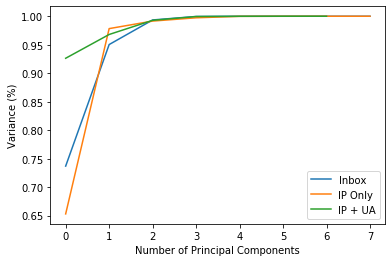

In [35]:
Inbox_pca, Inbox_fit = getPCA_Fit(df_Inbox_agg_unsup_s)
IP_pca, IP_fit = getPCA_Fit(df_IP_agg_unsup_s)
IPUA_pca, IPUA_fit = getPCA_Fit(df_IPUA_agg_unsup_s)

plt.figure()
plt.plot(np.cumsum(Inbox_pca.explained_variance_ratio_), label="Inbox")
plt.plot(np.cumsum(IP_pca.explained_variance_ratio_), label="IP Only")
plt.plot(np.cumsum(IPUA_pca.explained_variance_ratio_), label="IP + UA")
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance (%)') 
plt.legend()
plt.show()

# print("explained_variance_ratio\n Inbox:{}\n IP Only:{}\n IP + UA:{}".format(Inbox_fit.explained_variance_ratio_, IP_fit.explained_variance_ratio_, IPUA_fit.explained_variance_ratio_))

In [74]:
kmeans_random_sate = 654657


def getKMeansIneritas(dfs, loops):
    result = defaultdict(list)
    for k in range(1,loops):
        km = KMeans(n_clusters=k, random_state = kmeans_random_sate)
        
        for df_name, df in dfs.items():
            km = km.fit(df)
            result[df_name].append(km.inertia_.copy())
            
    return result

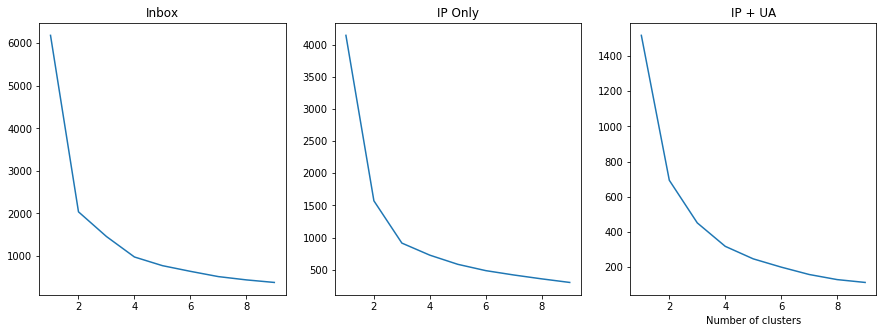

In [75]:
loops = 10

k_means_data = {'Inbox':df_Inbox_agg_unsup_s, 'IP Only':df_IP_agg_unsup_s, 'IP + UA':df_IPUA_agg_unsup_s}
k_means_ineritas = getKMeansIneritas(k_means_data, loops)
cnt = len(k_means_ineritas)
i=0

f = plt.figure(figsize=(15, 5))    
gs = f.add_gridspec(1,cnt)

for df_name, ineritas in k_means_ineritas.items():
    ax = f.add_subplot(gs[i])
    plt.plot(range(1,loops),ineritas)
    plt.title(df_name)   
    i += 1

plt.show()

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


### We see a change in slope around 3, but still has a relatively large avg distance.

### We should try some runs between 3 and 5 and only show the best results below.


## After running 3, 4 and 5 clusters: 
### 5 was determined to be the clustering count.

This was done by exporting the K-Means labels and appending the label to the raw non-anonymized data in SQL.  Manual sampling was done to determine the best separation of suspected BOTs and organic click activity.

### Instantiate the KMeans class with clusters = 5
Run fit and get the ndarray of the predicted labels

We will use this array to append a new series onto existing DataFrames


In [ ]:
model = KMeans(n_clusters=5, random_state = kmeans_random_sate)
model.fit(df_IPSession_transformed)
labels = model.predict(df_IPSession_transformed)

print(labels[:20])

#### Make sure the indexes and cardinality of the DataFrames and K-Means lables are a match

In [ ]:
print("\
Index of groupby = {}\n\
Index of transformed = {}\n\
Index of KMeans Columns = {}"
      .format( 
              df_IPSession.index.name,
              df_IPSession_transformed.index.name, 
              df_IPSession_KMeans_columns.index.name
             ))

print("\
Len of groupby = {}\n\
Len of transformed = {}\n\
Len of KMeans Columns = {}\n\
Len of lables = {}"
      .format( 
              len(df_IPSession), 
              len(df_IPSession_transformed), 
              len(df_IPSession_KMeans_columns), 
              len(labels)
              ))

## Append the KMean Lables to the 2 IP group by DataFrames

In [ ]:
df_IPSession['IP_KMean'] = labels #Origional Group By with additional agg columns
df_IPSession_transformed['IP_KMean'] = labels #Normilized Aggregations
df_IPSession_KMeans_columns['IP_KMean'] = labels #Not=Normilized Aggregations


df_IPSession_transformed.hist(figsize=(15,15))

## Build visualizations to manually inspect effectiveness of clusters

In [ ]:
palette = {0:'r', 1:'g',2:'y', 3:'Purple', 4:'b'}
f = plt.figure(figsize=(10, 20))
gs = f.add_gridspec(5, 2)

ax = f.add_subplot(gs[0, 0])
sns.stripplot(x='IP_KMean', y='RequestCount', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[0, 1])
sns.stripplot(x='IP_KMean', y='UniqueInboxIDs', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[1, 0])
sns.stripplot(x='IP_KMean', y='UniqueUserAgents', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[1, 1])
sns.stripplot(x='IP_KMean', y='UniqueUserAgents/RequestCount', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[2, 0])
sns.stripplot(x='IP_KMean', y='UniqueEmails', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[2, 1])
sns.stripplot(x='IP_KMean', y='UniqueEmailDomains', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[3, 0])
sns.stripplot(x='IP_KMean', y='MeanSendRequestSeconds_ln', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[3, 1])
sns.stripplot(x='IP_KMean', y='MeanSendRequestSeconds', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[4, 0])
sns.stripplot(x='IP_KMean', y='SessionDuration', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[4, 1])
sns.stripplot(x='IP_KMean', y='UniqueLinks', palette=palette, data=df_IPSession)

f.tight_layout()
plt.show()

### Label 1 stands out, esplishely in UniqueEmails and RequestCount
### Low UserAgent to RequestCount ratios for labels 1 and 4

In [ ]:
f = plt.figure(figsize=(12, 12))
gs = f.add_gridspec(2, 1)

ax = f.add_subplot(gs[0])
sns.scatterplot(y='UniqueLinks', x='RequestCount', hue='IP_KMean', palette=palette, data=df_IPSession)

ax = f.add_subplot(gs[1])
sns.scatterplot(y='UniqueUserAgents', x='RequestCount', hue='IP_KMean', palette=palette, data=df_IPSession)

f.tight_layout()
plt.show()

### Most organic click activity will have a unique link pre request.  There will be a few contact's that click on the same link more than one time.

### But label 4 has hundreds of click requests with just 10 to 20 unique links.  This is very suspicious of BOT activity.


In [ ]:
#todo: np.seterr(divide='ignore', invalid='ignore')
# Find out what the warnning is about.  i.e. More cleanup on MeanSendRequestSeconds_ln
np.seterr(divide='ignore', invalid='ignore') 

In [ ]:
pairplot_columns = agg_columns
pairplot_columns = pairplot_columns[:3]
pairplot_columns.append("IP_KMean")
pairplot_df = df_IPSession[pairplot_columns]
sns.pairplot(pairplot_df, hue="IP_KMean", height=2.8, palette=palette)

In [ ]:
pairplot_columns = agg_columns
pairplot_columns = pairplot_columns[3:6]
pairplot_columns.append("IP_KMean")
pairplot_df = df_IPSession[pairplot_columns]
sns.pairplot(pairplot_df, hue="IP_KMean", height=2.8, palette=palette)

In [ ]:
pairplot_columns = agg_columns
pairplot_columns = pairplot_columns[6:]
pairplot_columns.append("IP_KMean")
pairplot_df = df_IPSession[pairplot_columns]
sns.pairplot(pairplot_df, hue="IP_KMean", height=2.8, palette=palette)

In [ ]:
df_IPSession_mean = df_IPSession.groupby(['IP_KMean']).agg({
                                                   'UniqueInboxIDs':'mean',
                                                   'UniqueEmails':'mean',
                                                   'UniqueUserAgents':'mean',
                                                   'UniqueEmailDomains':'mean',
                                                   'UniqueEmailRootLevelDomain':'mean',
                                                   'UniqueLinks':'mean',
#                                                    'MeanSendRequestSeconds':'mean',
#                                                    'SessionDuration':'mean',
                                                   'UniqueUserAgents/RequestCount':'mean',
                                                    })
df_IPSession_mean = df_IPSession_mean.transpose()

df_IPSession_std = df_IPSession.groupby(['IP_KMean']).agg({
                                                   'UniqueInboxIDs':'std',
                                                   'UniqueEmails':'std',
                                                   'UniqueUserAgents':'std',
                                                   'UniqueEmailDomains':'std',
                                                   'UniqueEmailRootLevelDomain':'std',
                                                   'UniqueLinks':'std',
#                                                    'MeanSendRequestSeconds':'std',
#                                                    'SessionDuration':'std',
                                                   'UniqueUserAgents/RequestCount':'std',
                                                    })
df_IPSession_std = df_IPSession_std.transpose()

f = plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)

plt.title("Means")
sns.heatmap(df_IPSession_mean, annot=True, cmap="YlGnBu", linewidths=1, linecolor='b') 
plt.tight_layout()
plt.show()


f = plt.figure(figsize=(8, 5))
plt.title("Standard Deviations")
sns.heatmap(df_IPSession_std, annot=True, cmap="YlGnBu", linewidths=1, linecolor='b') 
plt.tight_layout()
plt.show()

# Merge the K-Means labels for IP GroupBy with original df

## Remember, so far we have been looking at the group by DataFrame

### Now that we merged the K-Mean Lables into the raw date, we will see different cardinality since many requests were rolled up in teh group by

In [ ]:
df_IPKMeans = pd.merge(df, df_IPSession['IP_KMean'], on="IPSessionID")

In [ ]:
p= pd.DataFrame(df_IPKMeans.groupby(['IP_KMean'])['InboxID'].count())
p = p.unstack(0, )
p = p.reset_index('IP_KMean')
p.columns = ['IP_KMean', 'RequestCount']
p.plot.bar('IP_KMean', 'RequestCount', figsize=(12,5))

In [ ]:
nunique_columns = [ 'InboxID',
                    'Company',
                    'List',
                    'Campaign',
                    'Link',
                    'IPAddress',
                    'UserAgent',
                    'AS Name',
                    'AS Number',
                    'CIDR Range',
                    'EmailDomain',
                    'EmailRootLevelDomain']
gb = df_IPKMeans.groupby(['IP_KMean'])[nunique_columns].nunique()
gb=gb.transpose()
gb

## Show distribution of these labels across the AS Names

In [ ]:
def groupByPivot(group_column_top, group_column_left, count_column):
    gb = df_IPKMeans.groupby([group_column_top, group_column_left])[count_column].count()
    gb.fillna(0, inplace=True)
    gb = gb.unstack(0)
    gb.fillna(0, inplace=True)
    gb['All'] = gb[0] + gb[1] + gb[3] + gb[4]
    gb.sort_values('All', ascending=False, inplace=True)
    return gb

In [ ]:
groupByPivot('IP_KMean', 'AS Name','InboxID')

In [ ]:
groupByPivot('IP_KMean', 'AS Number','InboxID')

In [ ]:
groupByPivot('IP_KMean', 'CIDR Range','InboxID').head(20)

## After manual review the 5 labels against the non-anomized data:
### The follow labels can be applied:

In [ ]:
manual_labels = {
                  0:'Organic_EarlyClickers', 
                  1:'Organic_SpreadOut_MultipleDevice', 
                  2:'Mixed', 
                  3:'Organic_SpreadOut_SingleDevice', 
                  4:'BOTS', 
                }
df_IPKMeans['Lables'] = df_IPKMeans['IP_KMean'].map(manual_labels)

### Save lables to csv file for manual analysis with raw non-anonymized data in SQL.

In [ ]:
select_columns = ['IPAddress', 'IP_KMean', 'Lables']
output = df_IPKMeans[select_columns].copy()
output.drop_duplicates(inplace=True)
output.to_csv('C:/data/IP_KMean_Lables.csv')
output